# Info
---

**Date**: 25/06/2022

**Author**: Savvas Chanlaridis

Based on the formulation presented in:

> "Spin-Down of Radio Millisecond Pulsars at Genesis"
by Thomas M. Tauris
DOI: [10.1126/science.1216355](10.1126/science.1216355)


---

# Index
---

### Moment of inertia
For a homogeneous solid sphere the moment of inertia is: $$I = \frac{2}{5}M_{\rm NS}R_{\rm NS}^2$$


### Magnetic dipole moment 
$$\mu = \frac{4\pi}{\mu_0} B R_{\rm NS}^3,$$ 
where $B$ is the magnetic flux density.



### Dipole energy loss
$$\dot{E}_{\rm dipole} = - \frac{2}{3c^3}|\ddot{\mu}|^2 = - \frac{2}{3c^3}\mu^2 \Omega_{\rm NS}^4 \sin^2(i),$$

where $\Omega$ is the spin frequency of the neutron star and $i$ the inclination angle.



### Light cylinder radius
Defines the outer boundary of closed B-field lines of the neutron star. $$r_{\rm lc} = \frac{c}{\Omega} = \frac{cP}{2\pi}$$



### Alfvén radius 
Defines the boundary of a pulsar's magnetosphere. It is obtained by equating the magnetic energy density to the ram pressure of the accreted matter. 


\begin{align*}
    r_{\rm A} &= B^{4/7} R_{\rm NS}^{12/7} \left(\dot{M} \sqrt{2GM_{\rm NS}} \right)^{-2/7} \approx \\\\
    &\approx (2.4 \times 10^8\,\text{cm}) \left(\frac{B}{10^{12}\,\text{Gauss}} \right)^{4/7} \left(\frac{R_{\rm NS}}{10\,\text{km}} \right)^{12/7} \left(\frac{\dot{M}}{10^{17}\,\text{g s$^{-1}$}} \right)^{-2/7} \left(\frac{M_{\rm NS}}{M_\odot} \right)^{-1/7},
\end{align*}

where $\dot{M}$ is the mass transfer rate.



### Magnetic radius 
Defines the location of inner edge of accretion disk. $$r_{\rm mag} = \phi r_{\rm A},\;\; \phi \in (0.5, 1.4)$$



### Corotation radius 
It is the radial distance at which the Keplerian angular frequency is equal to the angular spin frequency of the neutron star. 

$$r_{\rm co} = \left( \frac{GM}{\Omega^2} \right)^{1/3} = \left(\frac{GMP^2}{4\pi^2} \right)^{1/3}$$



### Accretion torque [as in Tauris (2012)]
$$N(t) = n(\omega) \left[ \dot{M}(t) \sqrt{GM_{\rm NS} r_{\rm mag}(t)} \xi + \frac{\mu^2}{9 r_{\rm mag}^3(t)} \right] - \frac{\dot{E}_{\rm dipole}(t)}{\Omega(t)},$$ 
where we defined the dimensionless quantity $$n(\omega) = \tanh \left( \frac{1- \omega}{\delta \omega} \right),$$

in order to model a gradual torque change in a transition zone near the magnetospheric boundary.

---

In [1]:
import mesa_reader as mr
import numpy as np

from astropy import units as u
from astropy import constants as const
from astropy.units import Quantity

from typing import Any, Union

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [ ]:
def moment_of_inertia(M: Any, R: Any) -> Quantity:
    """
    RETURN
    ======
        - The moment of inertia for a solid homogeneous sphere; Units [Kg m^(2)]
    ARGS
    =====
        - M : the mass of the neutron star; Units [Msun]
        - R : the radius of the neutron star; Units [km]
    """
    M = u.Quantity(M, u.Msun)
    R = u.Quantity(R, u.km)

    return ((2./5.) * M * (R**2.)).decompose()



def magnetic_moment(B: Any, R: Any) -> Quantity:
    """
    RETURN
    ======
        - The magnetic dipole moment; Units [A m^(2)]
    ARGS
    =====
        - B : the magnetic flux density; Units [G]
        - R : the radius of the neutron star; Units [km]
    """
    B = u.Quantity(B, u.gauss)
    R = u.Quantity(R, u.km)

    return ((4.*np.pi*B*(R**3.))/(const.mu0)).decompose()



def dipole_energy_loss(mu: Any, fspin: Any, i: Any) -> Quantity:
    """
    RETURN
    ======
        - Loss of rotational energy due to emission of magnetodipole waves; Units [Kg m^(2) s^(-3)]
    ARGS
    =====
        - mu    : the magnetic dipole moment; Units [A m^(2)]
        - fspin : the spin frequency of the neutron star; Units [Hz]
        - i     : the incination angle; Units [rad]
    """
    fspin = u.Quantity(fspin, u.hertz)
    mu = u.Quantity(mu, u.ampere * (u.meter**2.))
    i = u.Quantity(i, u.rad)

    # The magnetic dipole moment is treated as a dimensionless quantity
    # For this reason, we multiply with mu0/4pi
    e = ((const.mu0/(4.*np.pi)) * (2.*(mu**2.)*((2.*np.pi*fspin)**4.)*(np.sin(i))**2.)/(3.*(const.c)**3.)).decompose()
    return e



def spin_period(fspin: Any) -> Quantity:
    """
    RETURN
    ======
        - The spin period of a neutron star; Units [sec]
    ARGS
    =====
        - fspin : the spin frequency of the neutron star; Units [Hz]
    """
    fspin = u.Quantity(fspin, u.hertz)

    return ((2.*np.pi) / spin_frequency).decompose()



def spin_frequency(Pspin: Any, omega: bool = False) -> Quantity:
    """
    RETURN
    ======
        - The spin frequency of a neutron star; Units [Hz]
    ARGS
    =====
        - Pspin : the spin period of the neutron star; Units [s]
        - omega : if True return the angular speed instead of spin frequency
    """
    Pspin = u.Quantity(Pspin, u.s)
    fspin = (1 / Pspin).to(u.hertz)
    Omega_vel = (2.*np.pi / Pspin).to(u.hertz)

    if omega:
        return Omega_vel
    else:
        return fspin



def lc_radius(fspin: Any) -> Quantity:
    """
    RETURN
    ======
        - The light cylinder radius; Units [m]
    ARGS
    =====
        - fspin : the spin frequency of the neutron star; Units [Hz]
    """
    fspin = u.Quantity(fspin, u.hertz)

    return (const.c / (2.*np.pi*fspin)).decompose()



def magnetic_radius(Mdot: Any,
                    B: Any,
                    R: Any,
                    M: Any,
                    phi: float) -> Quantity:
    """
    RETURN
    ======
        - The magnetic radius; Units [m]
    ARGS
    =====
        - Mdot : the mass accretion rate; Units [Msun yr^(-1)]
        - B    : the magnetic flux density; Units [G]
        - R    : the radius of the neutron star; Units [km]
        - M    : the mass of the neutron star; Units [Msun]
        - phi  : a factor between 0.5 and 1.4
    """

    Mdot = u.Quantity(Mdot, u.M_sun / u.year)
    B = u.Quantity(B, u.gauss)
    R = u.Quantity(R, u.km)
    M = u.Quantity(M, u.Msun)
    phi = u.Quantity(phi, u.dimensionless_unscaled)

    alfven_radius = ((4. * np.pi / const.mu0) ** (2./7.) * (B**(4./7.)) * (R**(12./7.)) * \
                     ((Mdot * np.sqrt(2. * const.G * M))**(-2./7.))).decompose()

    magnetic_radius = phi * alfven_radius

    if magnetic_radius < R.to(u.meter):
        return R.to(u.meter)
    else:
        return magnetic_radius



def corotation_radius(P: Any, M: Any) -> Quantity:
    """
    RETURN
    ======
        - The corotation radius; Units [m]
    ARGS
    =====
        - P : the Keplerian period; Units [days]
        - M : the mass of the neutron star; Units [Msun]
    """
    P = u.Quantity(P, u.day)
    M = u.Quantity(M, u.Msun)

    return (((const.G * M * (P**2.))/(4.*(np.pi**2.)))**(1./3.)).decompose()



def fastness_parameter(r_mag: Any, r_co: Any) -> Quantity:
    """
    RETURN
    ======
        - The fastness parameter;
    ARGS
    =====
        - r_mag : the magnetic radius; Units [m]
        - r_co  : the corotation radius; Units [m]
    """
    r_mag = u.Quantity(r_mag, u.meter)
    r_co = u.Quantity(r_co, u.meter)

    return ((r_mag / r_co)**(3/2)).decompose()



def eq_spin_frequency(Mdot: Any,
                    M: Any,
                    R: Any,
                    B: Any,
                    Mdot_edd: Any = 3.0e-8) -> Quantity:
    """
    RETURN
    ======
        - The equilibrium spin frequency; Units [Hz]
    ARGS
    =====
        - Mdot     : the mass accretion rate; Units [Msun yr^(-1)]
        - M        : the mass of the neutron star; Units [Msun]
        - R        : the radius of the neutron star; Units [km]
        - B        : the magnetic flux density; Units [G]
        - Mdot_edd : the mass accretion Eddington limit; Units [Msun yr^(-1)]
    """
    Mdot = u.Quantity(Mdot, u.Msun / u.yr)
    B = u.Quantity(B, u.gauss)
    Mdot_edd = u.Quantity(Mdot_edd, u.Msun / u.yr)
    M = u.Quantity(M, u.Msun)
    R = u.Quantity(R, u.km)

    pmin = 0.71 *u.ms * (B/(1e8*u.gauss)) ** (6./7.) * (Mdot /(0.1*Mdot_edd))**(-3./7.) * \
        (M/(1.4*u.Msun)) ** (-5./7.) * (R/(10*u.km))**(18./7.)

    return (1/pmin).to(u.Hz)



def accretion_torque(Mdot: Any,
                    P: Any,
                    fspin: Any,
                    B: Any,
                    M: Any,
                    R: Any,
                    i: Any,
                    phi: float = 1.0,
                    xi: float = 1.0,
                    delta_omega: float = 0.002) -> Quantity:
    """
    RETURN
    ======
        - The accretion torque based on Tauris (2012)
        (https://arxiv.org/pdf/1202.0551.pdf); Units [kg m^(2) s^(-2)]
    ARGS
    =====
        - Mdot        : the mass accretion rate; Units [Msun yr^(-1)]
        - P           : the Keplerian period; Units [days]
        - fspin       : the spin frequency of the neutron star; Units [Hz]
        - B           : the magnetic flux density; Units [G]
        - M           : the mass of the neutron star; Units [Msun]
        - R           : the radius of the neutron star; Units [km]
        - i           : the inclination angle; Units [rad]
        - phi         : a factor between 0.5 and 1.4 to calculate the magnetic radius
        - xi          : a factor ...
        - delta_omega : the width of transition zone near the magnetospheric boundary.
    """

    Mdot = u.Quantity(Mdot, u.Msun / u.yr)
    P = u.Quantity(P, u.day)
    fspin = u.Quantity(fspin, u.hertz)
    B = u.Quantity(B, u.gauss)
    M = u.Quantity(M, u.Msun)
    R = u.Quantity(R, u.km)
    i = u.Quantity(i, u.rad)
    phi = u.Quantity(phi, u.dimensionless_unscaled)
    xi = u.Quantity(xi, u.dimensionless_unscaled)
    delta_omega = u.Quantity(delta_omega, u.dimensionless_unscaled)



    r_mag = magnetic_radius(Mdot=Mdot, B=B, R=R, M=M, phi=phi)
    r_co = corotation_radius(P=P, M=M)
    omega = fastness_parameter(r_mag=r_mag, r_co=r_co)
    mu = magnetic_moment(B=B, R=R)
    energy_loss = dipole_energy_loss(mu=mu, fspin=fspin, i=i)

    step_function = np.tanh(((1. - omega)/delta_omega) * u.rad)


    # Multiply 2nd term with mu0/4pi to make dipole moment
    # a dimensionless quantity. This results to N having units of [N m]
    N1 = (step_function * (Mdot * np.sqrt(const.G * M * r_mag) * xi)).decompose()
    N2 = (step_function * (const.mu0/(4.*np.pi)) * (mu**2. / (9.*(r_mag**3.)))).decompose()
    N3 = ((energy_loss)/(2.*np.pi*fspin)).decompose()

    N = N1 + N2 - N3

    return N



def evolve_pulsar(time: Any,
               mass_transfer_rate: Any,
               ns_mass: Any,
               ns_radius: Any = 10.0,
               magnetic_field: Any = 1e8,
               spin_period: Any = 10,
               medd: Any = 3.0e-8,
               zone_width: float = 0.002,
               factor_phi: float = 1.0,
               factor_xi: float = 1.0,
               inclination_angle: Any = np.pi/2) -> Quantity:
    """
    RETURN
    ======
        - The evolution of spin.
        - The evolution of minimum spin period (equilibrium).
        - The evolution of fastness parameter.
        - The evolution of magnetic radius.
        - The evolution of corotation radius.
        - The evolution of torque.
    ARGS
    =====
        - time               : the time period of the evolution; Units [yr]
        - mass_transfer_rate : the mass accretion rate; Units [Msun yr^(-1)]
        - ns_mass            : the mass of the neutron star; Units [Msun]
        - ns_radius          : the radius of the neutron star; Units [km]
        - magnetic_field     : the magnetic flux density; Units [G]
        - spin_period        : the initial spin period of the NS; Units [ms]
        - medd               : the Eddington accretion limit; Units [Msun yr^(-1)]
        - zone_width         : the width of transition zone near the magnetospheric boundary.
        - factor_phi         : a factor between 0.5 and 1.4 to calculate the magnetic radius
        - factor_xi          : a factor ...
        - inclination_angle  : the inclination angle; Units [rad]
    """

    time = u.Quantity(time, u.yr)
    mass_transfer_rate = u.Quantity(mass_transfer_rate, u.Msun/u.yr)
    ns_mass = u.Quantity(ns_mass, u.Msun)
    ns_radius = u.Quantity(ns_radius, u.km)
    magnetic_field = u.Quantity(magnetic_field, u.Gauss)
    spin_period = u.Quantity(spin_period, u.ms)
    medd = u.Quantity(medd, u.Msun/u.yr)
    inclination_angle = u.Quantity(inclination_angle, u.rad)

    fast_par = np.zeros_like(time.value)
    mag_rad = np.zeros_like(time.value) * u.meter
    cor_rad = np.zeros_like(time.value) * u.meter
    torque = np.zeros_like(time.value) * u.kg * u.meter**2 / u.s**2
    spin = np.zeros_like(time.value) * u.s
    pmin = np.zeros_like(time.value) * u.s
    omega = np.zeros_like(time.value) * u.hertz

    # The timestep
    delta_t = u.Quantity(np.diff(time.value), u.yr)

    for i in range(0,len(time)):


        if i == 0: # Initialization clause
            spin[i] = spin_period
            omega[i] = 2*np.pi / spin[i]

            mag_rad[i] = magnetic_radius(Mdot=mass_transfer_rate[i],
                                         B=magnetic_field,
                                         R=ns_radius,
                                         M=ns_mass[i],
                                         phi=factor_phi)

            cor_rad[i] = corotation_radius(P=spin[i], M=ns_mass[i])

            fast_par[i] = fastness_parameter(r_mag=mag_rad[i], r_co=cor_rad[i])

            torque[i] = accretion_torque(Mdot=mass_transfer_rate[i],
                                 P=spin[i],
                                 fspin=(1/spin[i]).to(u.hertz),
                                 B=magnetic_field,
                                 M=ns_mass[i],
                                 R=ns_radius,
                                 i=inclination_angle,
                                 phi=factor_phi,
                                 xi=factor_xi,
                                 delta_omega=zone_width)


            pmin[i] = (1/eq_spin_frequency(mass_transfer_rate[i], ns_mass[i],
                                           ns_radius, magnetic_field, medd)).to(u.s)


        else:

            omega[i] = omega[i-1] + ((torque[i-1] * delta_t[i-1]) / \
                                                moment_of_inertia(ns_mass[i],ns_radius))

            spin[i] = (2*np.pi/omega[i])

            mag_rad[i] = magnetic_radius(Mdot=mass_transfer_rate[i],
                                         B=magnetic_field,
                                         R=ns_radius,
                                         M=ns_mass[i],
                                         phi=factor_phi)

            cor_rad[i] = corotation_radius(P=spin[i], M=ns_mass[i])

            fast_par[i] = fastness_parameter(r_mag=mag_rad[i], r_co=cor_rad[i])

            torque[i] = accretion_torque(Mdot=mass_transfer_rate[i],
                                 P=spin[i],
                                 fspin=(1/spin[i]).to(u.hertz),
                                 B=magnetic_field,
                                 M=ns_mass[i],
                                 R=ns_radius,
                                 i=inclination_angle,
                                 phi=factor_phi,
                                 xi=factor_xi,
                                 delta_omega=zone_width)

            pmin[i] = (1/eq_spin_frequency(mass_transfer_rate[i], ns_mass[i],
                                           ns_radius, magnetic_field, medd)).to(u.s)

    return (spin, pmin, fast_par, mag_rad, cor_rad, torque)


In [ ]:
def plotter(age: np.ndarray,
            mass: np.ndarray,
            mdot: np.ndarray,
            from_idx: int = 0,
            to_idx: Union[int, None] = None,
            save: bool = False,
            name: str = 'spin_evolution') -> None:
    
    """
    Some simple function to test and plot
    the Tauris' implementation.
    
    ARGS
    =====
        - age      : the age of NS
        - mass     : the mass of NS
        - mdof     : the mass accretion rate
        - from_idx : the starting index of the slice
        - to_idx   : the finishing index of the slice
        - save     : if True, then save the figure
        - name     : the name of the saved figure
    """

    B_fields = [1e8, 10**8.5, 1e9]
    B_tag = [r'$10^{8}$', r'$10^{8.5}$', r'$10^{9}$']
    spin_periods = [1., 15., 40.]
    colors = ['b', 'g', 'r']
    styles = ['--', '-.', ':']

    legend_elements = [Line2D([0], [0], color='b', lw=4, label=r'$P_{\rm spin} = 1\;$ ms'),
                   Line2D([0], [0], color='g', lw=4, label=r'$P_{\rm spin} = 15\;$ ms'),
                   Line2D([0], [0], color='r', lw=4, label=r'$P_{\rm spin} = 40\;$ ms'),
                   Line2D([0], [0], color='k', lw=4, label=r'$P_{\rm min}$'),
                   Line2D([0], [0], ls='--', color='k', label=r'$B = 10^8\;$G'),
                   Line2D([0], [0], ls='-.', color='k', label=r'$B = 10^{8.5}\;$G'),
                   Line2D([0], [0], ls=':', color='k', label=r'$B = 10^9\;$G')]


    for i, field in enumerate(B_fields):
        ls = styles[i]
        tag = B_tag[i]
        for j, period in enumerate(spin_periods):
            c = colors[j]
            spin, pmin, fast_par, mag_rad, cor_rad, torque = evolve_pulsar(age, mdot, mass,
                                                                           spin_period=period,
                                                                           magnetic_field=field)

            _ = plt.plot(age[from_idx:to_idx]/1e9, 10**np.log10(spin[from_idx:to_idx].value/0.001), 
                         c=c, ls=ls, lw=0.5)
            
            _ = plt.plot(age[from_idx:to_idx]/1e9, 10**np.log10(pmin[from_idx:to_idx].value/0.001), 
                         c='k', ls=ls, lw=0.5)

    plt.xlabel("Age [Gyr]")
    plt.ylabel("Spin period [ms]")
    plt.title(r'$M_{\rm NS}^{i} = 2.18\,M_\odot$, $M_{\rm WD}^{i} = 0.40\,M_\odot$')
    plt.ylim(-0.5, 45)
    _ = plt.legend(handles=legend_elements, loc='best', frameon=False)

    if save:
        plt.savefig('{}.pdf'.format(name), dpi=300, bbox_inches='tight')
    else:
        plt.show()

In [ ]:
# if __name__ == "__main__":

#     h = mr.MesaData('history_017_preaic.data').data
#     # h = mr.MesaData('history2_040_preaic.data').data

#     time = h('age')
#     ns_mass = h('star_2_mass')
#     accretion_rate = 10**h('lg_mstar_dot_2')

#     plotter(time, ns_mass, accretion_rate, save=False, from_idx=1370)

## Test of spin evolution

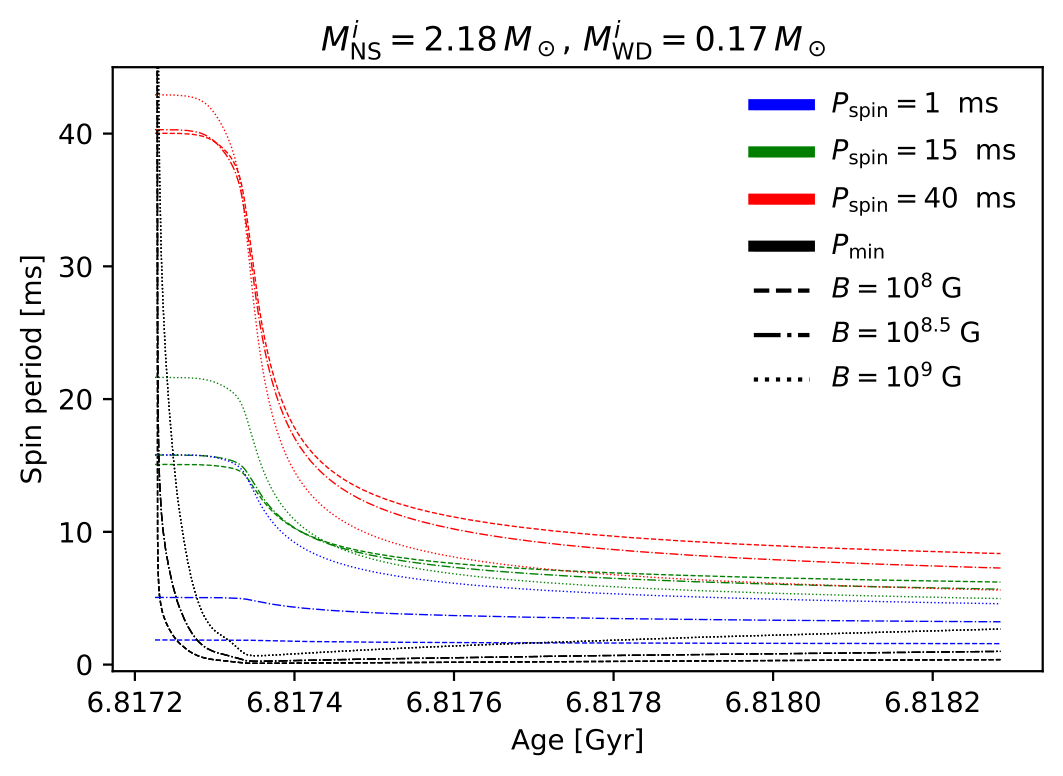